# Сеть для распознавания номиналов монет

## Импорт библиотек

In [25]:
import pickle

import matplotlib.pyplot as plt
import cv2

%matplotlib inline

In [26]:
import numpy as np
import theano
import theano.tensor as T
import lasagne

In [27]:
import sys
import os
import time

## Загружаем базу изображений

In [28]:
def get_image(image_name):
    img = cv2.imread(image_name)
    img = cv2.resize(img, (64, 64))
    img = np.reshape(img, (3, 64, 64))
    return img

In [29]:
IMGS_PATH = ''
def get_by_dir(directory, num=None):
    imgs_names = os.listdir(directory)
    
    if num is not None:
        imgs_names = imgs_names[:num]
    out = []
    for img_name in imgs_names:
        out.append(get_image(directory+img_name))
    return out

In [30]:
def get_data(list_of_dirs, num=None):
    images = []
    labels = []
    for directory, name in list_of_dirs:
        print(directory, name)
        img = get_by_dir(directory, num)
        labels.extend([name for x in range(len(img))])
        images.extend(img)
    return images, labels

In [31]:
list_of_dirs = [['D:\\Camera\\1r\\', 0],
                ['D:\\Camera\\2r\\', 1],
                ['D:\\Camera\\5r\\', 2],
                ['D:\\Camera\\10k\\', 3],
                ['D:\\Camera\\10r\\', 4],
                ['D:\\Camera\\50k\\', 5],
               ]
images, labels = get_data(list_of_dirs, 800)
images = images / np.float32(256)
images_test = [images[i] for i in range(len(images)) if i%3 == 2]
labels_test = [labels[i] for i in range(len(labels)) if i%3 == 2]
images = [images[i] for i in range(len(images)) if i%3 == 0 or i%3 == 1]
labels = [labels[i] for i in range(len(labels)) if i%3 == 0 or i%3 == 1]

D:\Camera\1r\ 0
D:\Camera\2r\ 1
D:\Camera\5r\ 2
D:\Camera\10k\ 3
D:\Camera\10r\ 4
D:\Camera\50k\ 5


In [32]:
print (len(images), len(labels))
print (len(images_test), len(labels_test))
labels = np.array(labels)
labels_test = np.array(labels_test)
images = np.array(images)
images_test= np.array(images_test)

3200 3200
1600 1600


## Haar для локализации монет

In [33]:
def haar_find_mony(cascade_file, image):
    haar_cascade = cv2.CascadeClassifier(cascade_file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    detects_location = haar_cascade.detectMultiScale(gray, 1.1, 1)
    
    return detects_location

## Сеть для поиска монет

In [34]:
def build_cnn(input_var=None):
    network = lasagne.layers.InputLayer(shape=(None, 3, 64, 64),
                                        input_var=input_var)
    
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=64, filter_size=(3, 3),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())

    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=128,
            nonlinearity=lasagne.nonlinearities.rectify)

    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=43,
            nonlinearity=lasagne.nonlinearities.softmax)

    return network

In [35]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [36]:
input_var = T.tensor4('inputs')
target_var = T.ivector('targets')

In [37]:
network = build_cnn(input_var)

In [38]:
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()

D:\Program Files\Anaconda3\lib\site-packages\lasagne\layers\conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


In [39]:
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(
            loss, params, learning_rate=0.01, momentum=0.9)

test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                            target_var)
test_loss = test_loss.mean()

test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                        dtype=theano.config.floatX)

D:\Program Files\Anaconda3\lib\site-packages\lasagne\layers\conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


In [40]:
pred = test_prediction.argmax(-1)
f_predict = theano.function([input_var], pred)

In [41]:
train_fn = theano.function([input_var, target_var], 
                           loss, 
                           updates=updates,
                           allow_input_downcast=True)

val_fn = theano.function([input_var, target_var], 
                         [test_loss, test_acc],
                         allow_input_downcast=True)

## Обучение сети для классификации монет

In [42]:
num_epochs = 15

In [43]:
BATCH_SIZE = 64

In [44]:
for epoch in range(num_epochs):
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(images, labels, BATCH_SIZE, shuffle=True):
        inputs, targets = batch
        train_err += train_fn(inputs, targets)
        train_batches += 1

    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(images_test, labels_test, BATCH_SIZE, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1
        
    print("Epoch: {}, train:{}, val:{}".format(epoch, 
                                               train_err/train_batches,
                                               val_err/val_batches))

Epoch: 0, train:1.8425047604469098, val:1.1887429201441622
Epoch: 1, train:1.224525635696179, val:1.495866617721045
Epoch: 2, train:1.0304444063477842, val:0.8191042382359309
Epoch: 3, train:0.8432442631956556, val:0.7049461511832237
Epoch: 4, train:0.7729204473241329, val:0.7250249145923857
Epoch: 5, train:0.7616572942023347, val:0.6292945655750808
Epoch: 6, train:0.6901140451396437, val:0.6186479316407676
Epoch: 7, train:0.6454665435961252, val:0.5310134742568363
Epoch: 8, train:0.6265137031540035, val:0.6146123795323053
Epoch: 9, train:0.5940656356925722, val:0.48237120668127176
Epoch: 10, train:0.5405944229059269, val:0.5278758804808054
Epoch: 11, train:0.5050225551231783, val:0.4859400017360855
Epoch: 12, train:0.47122333645064457, val:0.4325444388083829
Epoch: 13, train:0.4435623683316006, val:0.5689934432286808
Epoch: 14, train:0.4389406745775181, val:0.4197242966301145


## Итого

In [45]:
y_true = []
y_pred = []

for i in range(len(labels_test)):
    y_true.append(int(labels_test[i]))
    y_pred.append(f_predict([images_test[i]])[0])

In [46]:
from sklearn.metrics import confusion_matrix

In [47]:
CM = confusion_matrix(y_true, y_pred)

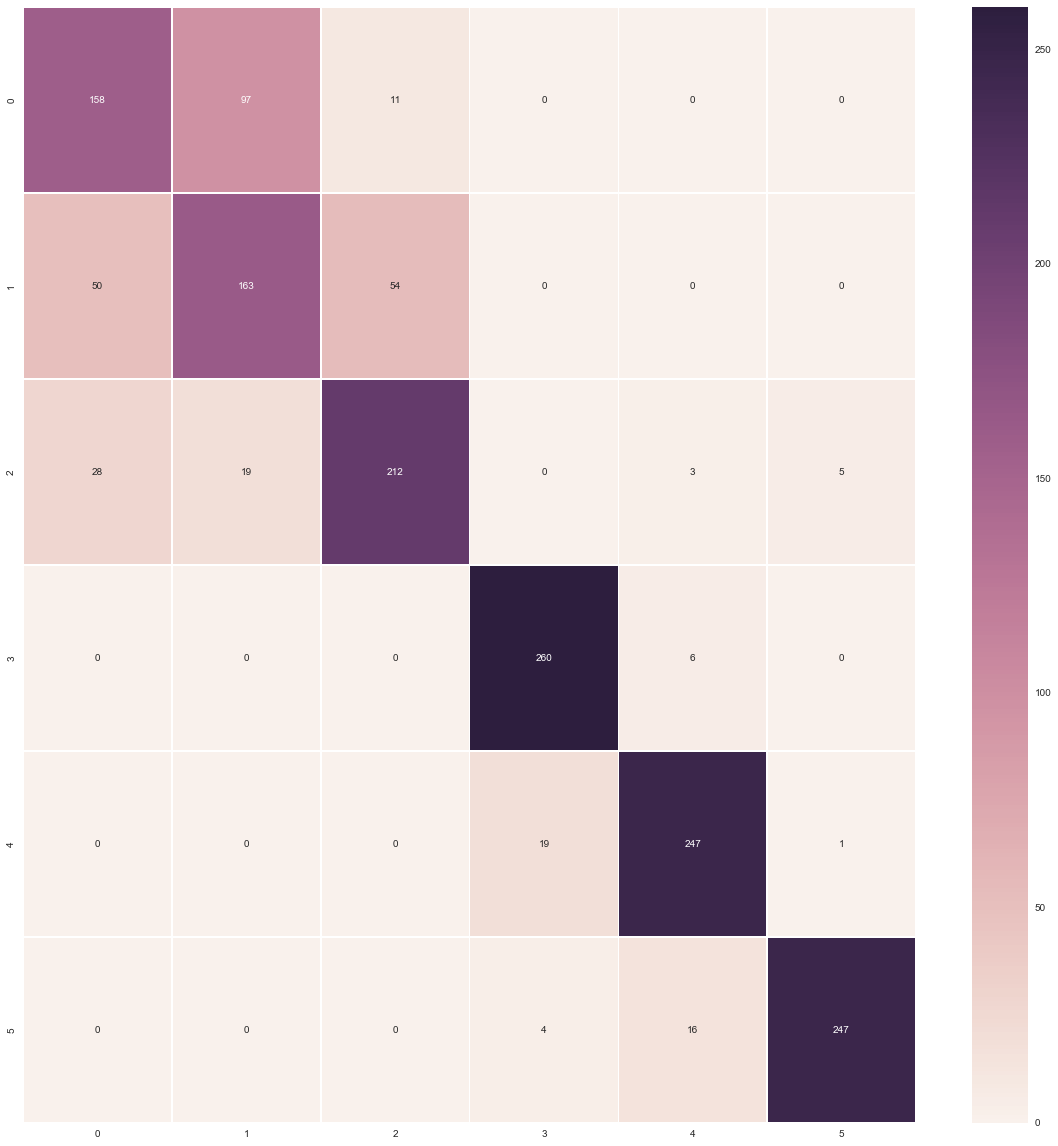

In [48]:
import seaborn as sns

fig = plt.figure(figsize=(20, 20))
sns.heatmap(CM, annot=True, fmt="d", linewidths=.5)
plt.show()